# ArchPy2Modflow: Energy Transport with Modflow 6

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
import sys
import os

# auto reload modules
%load_ext autoreload
%autoreload 2

sys.path.append("../../")
#my modules
from ArchPy.base import *
from ArchPy.tpgs import *

In [2]:
#grid
sx = 1.5
sy = 1.5
sz = .15
x0 = 0
y0 = 0
z0 = -15
nx = 100
ny = 50
nz = 50
x1 = x0 + nx*sx
y1 = y0 + ny*sy
z1 = z0 + nz*sz

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

In [3]:
## create pile

P1 = Pile(name = "P1",seed=1)

#units covmodel
covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodelD1 = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[30,30]})])
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[40,40]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[50,50]})])

# facies covmodels
covmodel_f_B = gcm.CovModel3D(elem=[('spherical', {'w':.25, 'r':[20, 20, 2]})])

#create Lithologies 
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD}
dic_f_D = {"f_method":"homogenous"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC, "mean":-8.5}
dic_f_C = {"f_method":"homogenous"}
C = Unit(name="C", order=2, ID = 2, color="blue", contact="onlap", dic_facies=dic_f_C, surface=Surface(dic_surf=dic_s_C, contact="onlap"))

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean":-9.5}
dic_f_B = {"f_method":"SIS", "f_covmodel":[covmodel_f_B], "probability":[0.3, 0.6, 0.1]}
B = Unit(name="B",order=3,ID = 3,color="purple",contact="onlap",dic_facies=dic_f_B,surface=Surface(contact="onlap",dic_surf=dic_s_B))

dic_s_A = {"int_method":"grf_ineq","covmodel": covmodelB, "mean":-13}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",order=4, ID = 4,color="red",contact="onlap",dic_facies=dic_f_A,surface=Surface(dic_surf = dic_s_A,contact="onlap"))

#Master pile
P1.add_unit([D,C,B,A])

Unit D: Surface added for interpolation
Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation
Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added


In [4]:
# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[30,30,10]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[20,20, 5]})],alpha=0,name="K_vario_2")

facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_1, facies_2, facies_4])
D.add_facies([facies_1])
C.add_facies([facies_4])

# property model

# K
cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.5, "r":[10, 10, 10]}),
                                  ("cubic", {"w":0.5, "r":[15, 15, 15]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.5, "r":[25, 25, 5]})])

list_facies = [facies_1, facies_2, facies_4, facies_7]
means = [-4, -2, -8, -10]
prop_model = ArchPy.base.Prop("K",
                              facies = list_facies,
                              covmodels = None,
                                means = means,
                                int_method = "homogenous",
                                vmin = -10,
                                vmax = -1
                                )

# porosity
cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.01, "r":[10, 10, 10]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.01, "r":[25, 25, 5]})])

porosity = ArchPy.base.Prop("Porosity",
                            facies = list_facies,
                            covmodels = [cm_prop2, cm_prop2, cm_prop2, cm_prop2],
                            means = [0.2, 0.3, 0.3, 0.05],
                            int_method = ["sgs", "sgs", "sgs", "homogenous"],
                            vmin = 0,
                            vmax = 0.4
                            )

# alh
cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.01, "r":[10, 10, 10]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.01, "r":[25, 25, 5]})])

long_disp = ArchPy.base.Prop("long_disp",
                            facies = list_facies,
                            covmodels = [cm_prop2, cm_prop2, cm_prop2, cm_prop2],
                            means = [1, 2, 10, .1],
                            int_method = ["homogenous", "homogenous", "homogenous", "homogenous"],
                            vmin = 0
                            )

Facies basement added to unit A
Facies Sand added to unit B
Facies Gravel added to unit B
Facies Clay added to unit B
Facies Sand added to unit D
Facies Clay added to unit C


In [5]:
top = np.ones([ny,nx])*z1
bot = np.ones([ny,nx])*z0

In [6]:
T1 = Arch_table(name = "P1",seed=3)
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot)
T1.add_prop([prop_model, porosity, long_disp])

Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Property K added
Property Porosity added
Property long_disp added


In [7]:
T1.compute_surf(1)
T1.compute_facies(1)
T1.compute_prop(1)

Boreholes not processed, fully unconditional simulations will be tempted
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.016229867935180664 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.01396322250366211 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.015206336975097656 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.04895520210266113 s
##########################


### 0.10239529609680176: Total time elapsed for computing surfaces ###

### Unit D: facies simulation with homogenous method ####
### Unit D - realization 0 ###
Time elapsed 0.0 s

### Unit C: facies simulation with homogenous method ####
### Unit C - realization 0 ###
Time elapsed 0.0 s

### Unit B: facies simulation with SIS method ####
### Unit B - realization 0 ##

In [8]:
pv.set_jupyter_backend("static")

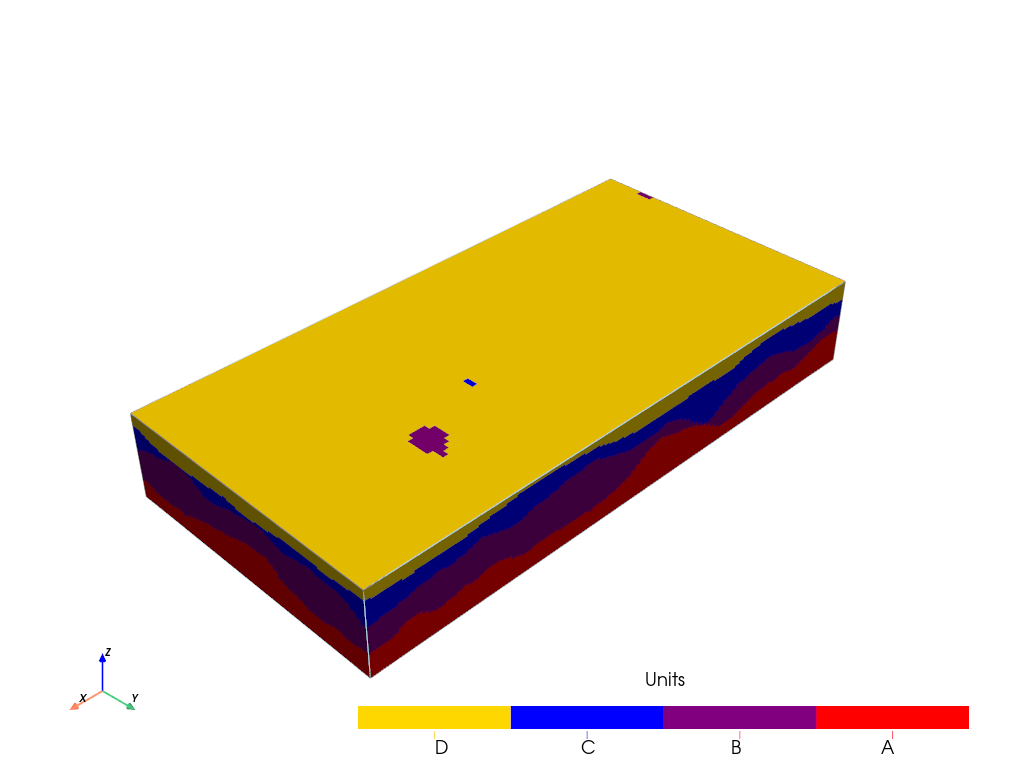

In [9]:
T1.plot_units(v_ex=3)

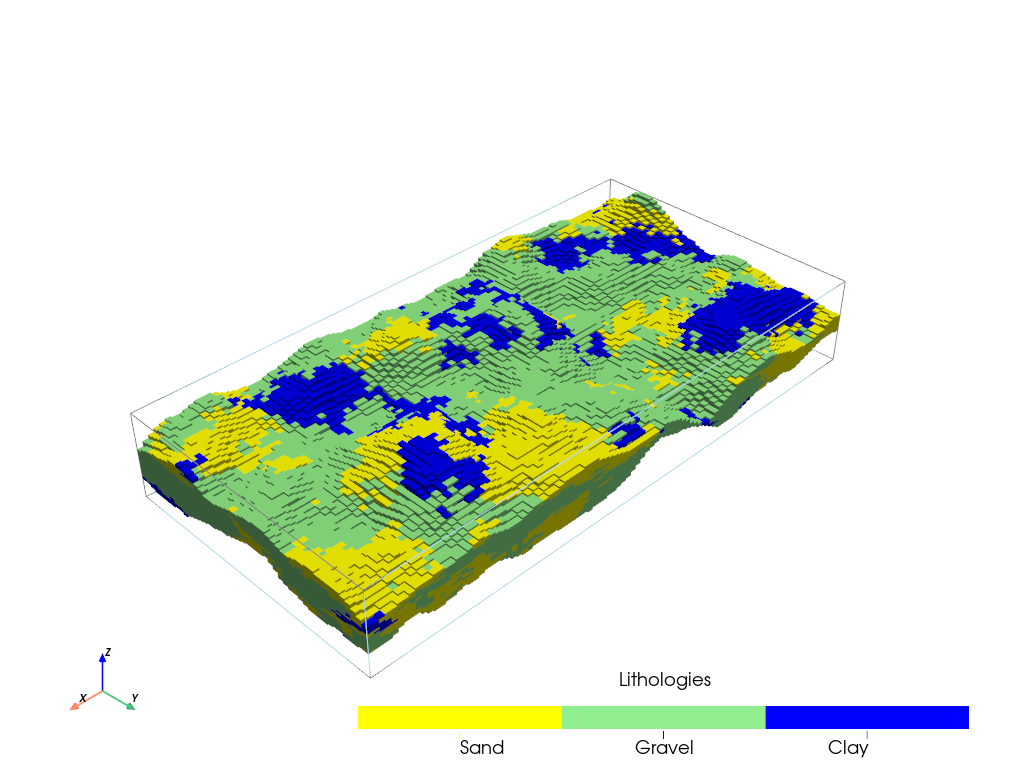

In [10]:
T1.plot_facies(inside_units=[B], v_ex=3)

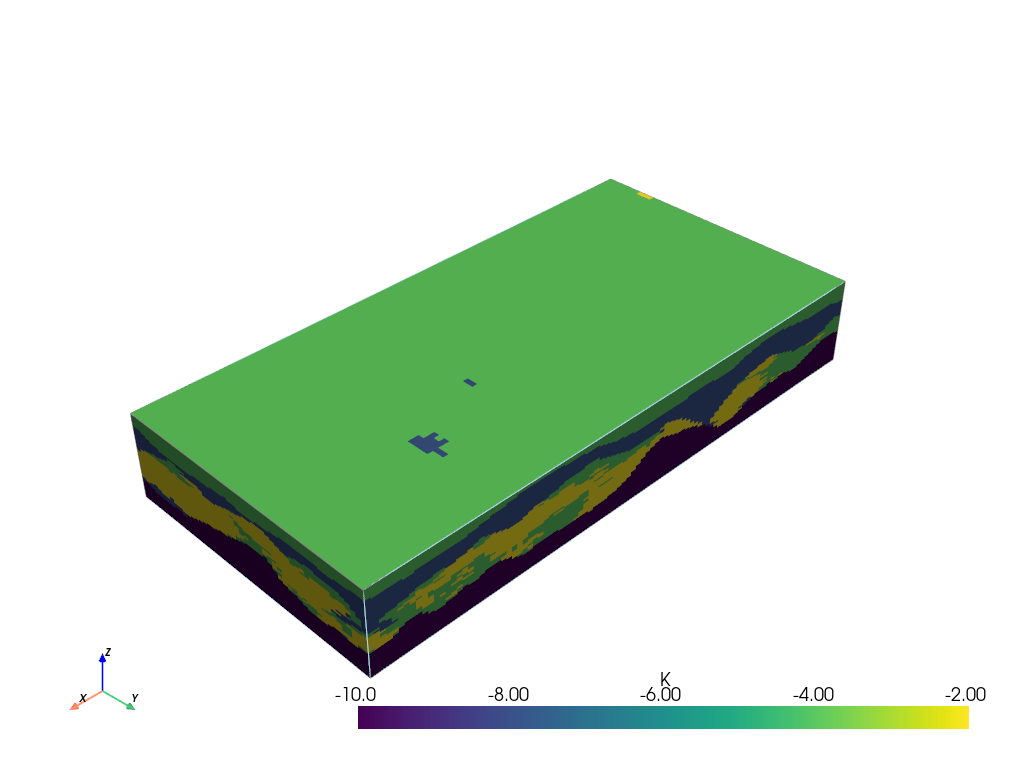

In [11]:
T1.plot_prop("K", v_ex=3)

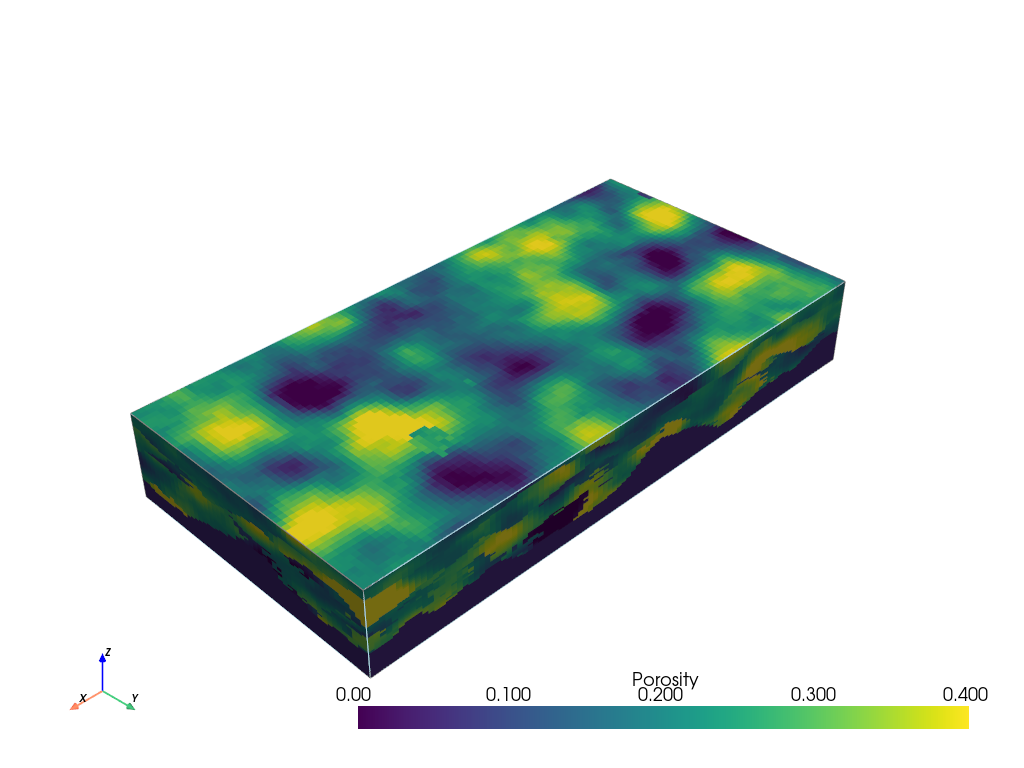

In [12]:
T1.plot_prop("Porosity", v_ex=3)

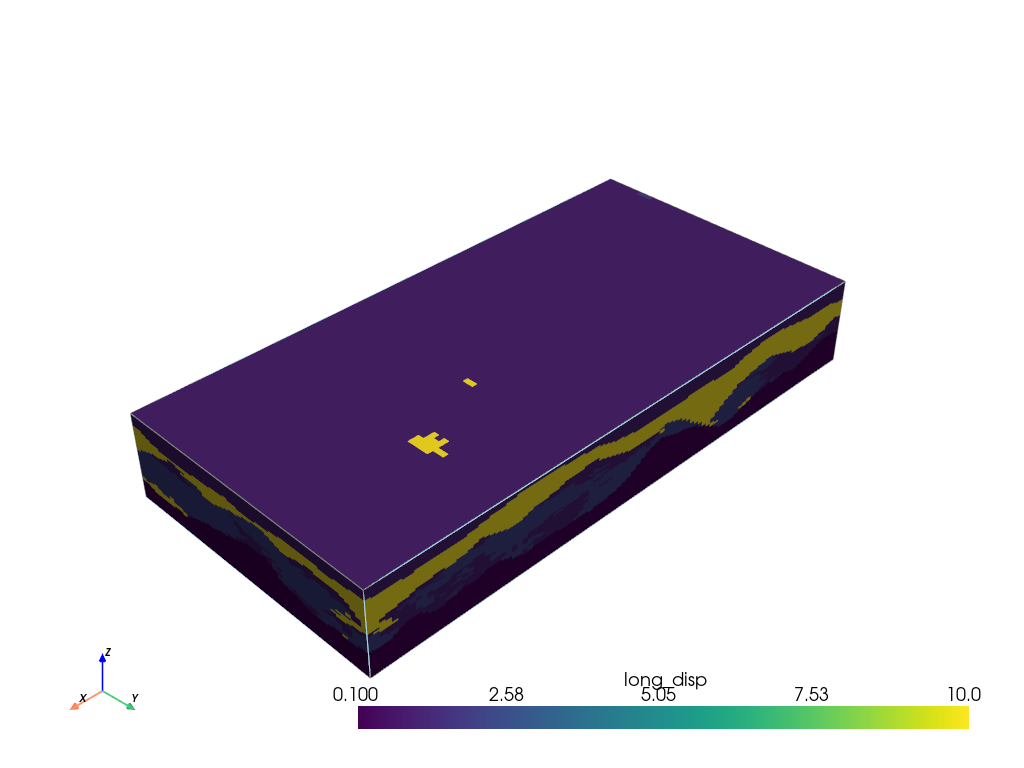

In [13]:
T1.plot_prop("long_disp", v_ex=3)

### Flow model

In [14]:
import ArchPy.ap_mf
from ArchPy.ap_mf import archpy2modflow, array2cellids

In [15]:
mf6_exe_path = "../../../../exe/mf6.exe"

In [16]:
nz

50

In [17]:
archpy_flow = archpy2modflow(T1, exe_name=mf6_exe_path)  # create the modflow model
archpy_flow.create_sim(grid_mode="layers", iu=0, unit_limit=None, lay_sep=[1, 1, 3, 1], factor_x=2, factor_y=2, factor_z=2)  # create the simulation object and choose a certain discretization
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True, k_average_method="anisotropic")  # set the hydraulic conductivity

Simulation created
To retrieve the simulation, use the get_sim() method


In [18]:
Porosity_up = archpy_flow.upscale_prop("Porosity")

In [19]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [20]:
import flopy as fp

In [21]:
sim.ims.remove()
inner_dvclose = 1e-5
ims = fp.mf6.ModflowIms(sim, complexity="moderate", inner_dvclose=inner_dvclose)

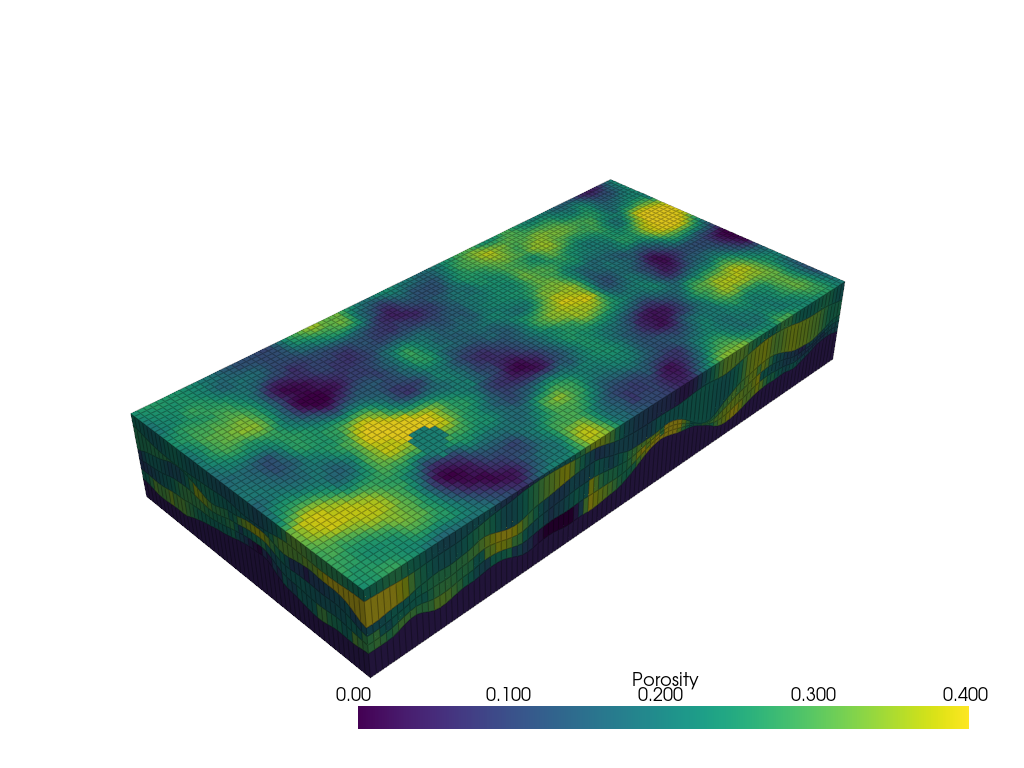

In [22]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

vtk.add_array(np.log10(gwf.npf.k.array), name="K")
vtk.add_array(Porosity_up, name="Porosity")
vtk.add_array(gwf.dis.idomain.array, name="IDOMAIN")
gwf_mesh = vtk.to_pyvista()

ghosts = np.argwhere(gwf_mesh["K"] > 1)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="Porosity", cmap="viridis", edge_opacity=0.3)
pl.show()

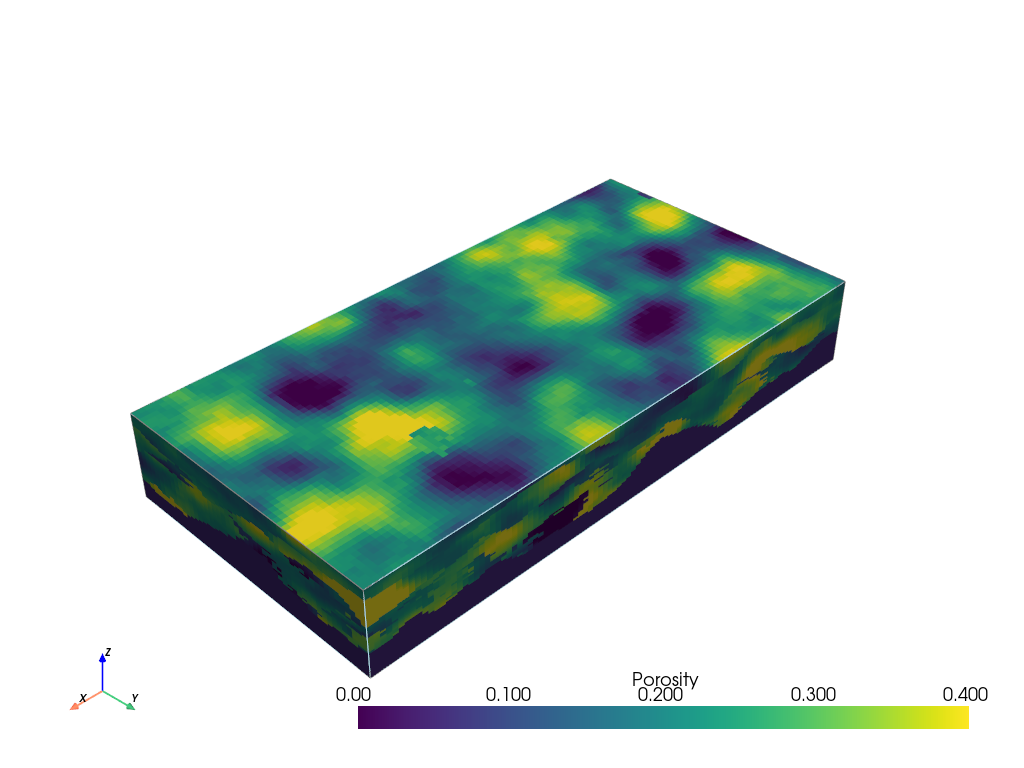

In [23]:
T1.plot_prop("Porosity", v_ex=3)

In [24]:
import flopy as fp

In [25]:
# add BC at left and right on all layers
h1 = .3
h2 = 0
T_1 = 10  # temperature at left boundary
T_2 = 10  # temperature at right boundary
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1, T_1))

chd1 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-1")

chd_data = []
a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2, T_2))

chd2 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-2")

In [26]:
# add an injection well in the middle of the model
well_data = []
Q_well = 0.001  # m3/s
T_well = 7  # temperature of the injected water
cellid_well = (2, T1.ny // 2, T1.nx // 2)
well_data.append((cellid_well, Q_well, T_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, auxiliary="TEMPERATURE", pname="WEL-INJ")

# production well
well_data = []
Q_well = -0.001  # m3/s
cellid_well = (2, T1.ny // 2, T1.nx // 3)
well_data.append((cellid_well, Q_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, pname="WEL-PROD")

In [27]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd-1...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 290 based on size of stress_period_data
    writing package chd-2...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 300 based on size of stress_period_data
    writing package wel-inj...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package wel-prod...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY

(True, [])

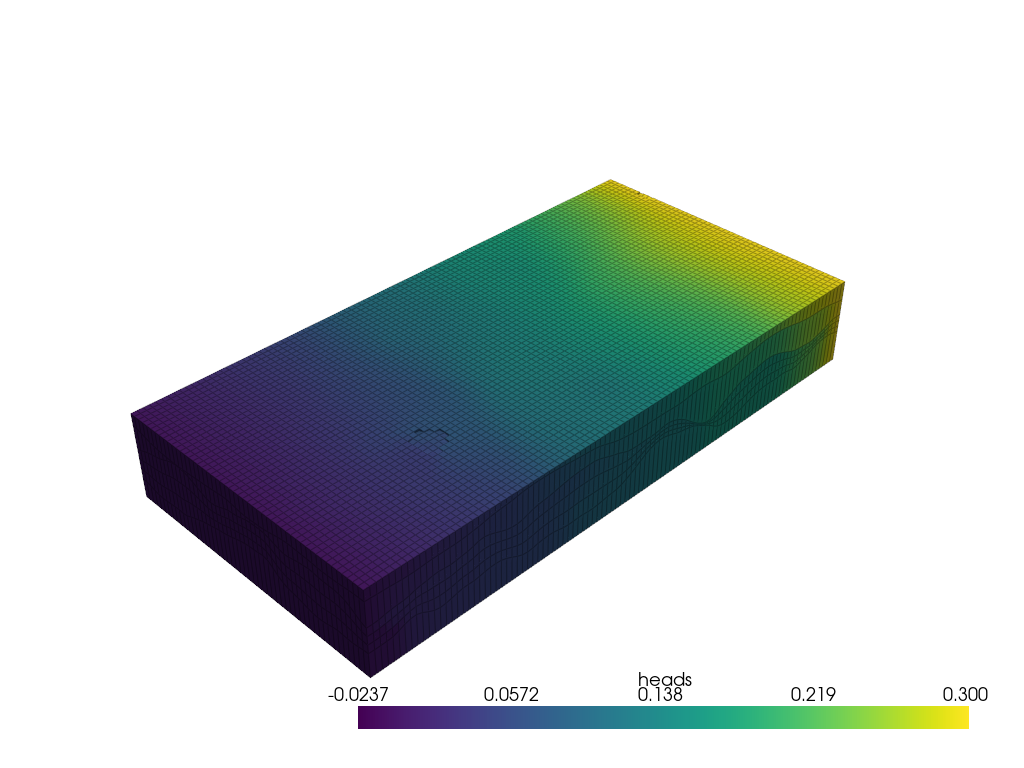

In [28]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(heads, name="heads")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="heads", cmap="viridis", edge_opacity=0.3)
pl.show()


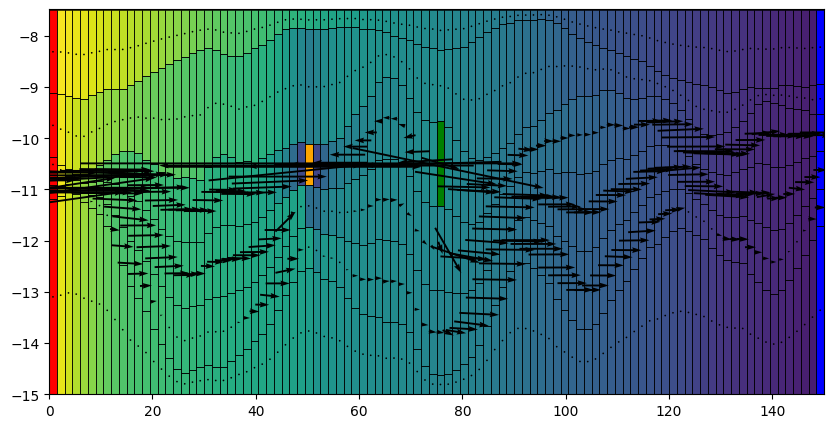

In [29]:
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

# plot cross section
from flopy.plot import PlotCrossSection
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cross_section = PlotCrossSection(model=gwf, line={"row": 25})
# cross_section.plot_array(np.log10(gwf.npf.k.array), cmap="Blues", ax=ax)
cross_section.plot_array(heads, cmap="viridis", ax=ax)
cross_section.plot_bc("CHD-1", color="red", ax=ax)
cross_section.plot_bc("CHD-2", color="blue", ax=ax)
cross_section.plot_bc("WEL-INJ", color="green", ax=ax)
cross_section.plot_bc("WEL-PROD", color="orange", ax=ax)
cross_section.plot_vector(qx, qy, qz, color="black", normalize=False)
cross_section.plot_grid(linewidth=0.5, color="black")

### Heat model

First heat model is create using the method "create_sim_energy". Several parameters can be specified such as thermal conductivity, specific heat capacity, density of both fluid and solid, and the porosity of the solid. Note here than only double values can be specified, if you want to use locally variable values you need to use appropriate set functions such as ``set_porosity``, ``set_cnd`` which set the **CND** modflow package and ``set_est`` which set the **EST** modflow package.

When these methods are called, it is possible to either provide, for each parameter, a single value (homogenous), an array-like object of values of the size of the model (e.g., (nlay, nrow, ncol) if the model use a structured grid) or a string, indicating the 
ArchPy property name to use for this parameter.

In [30]:
archpy_flow.create_sim_energy(strt_temp=10, ktw=0.56, kts=2.5, al=1, ath1=.1,
                              prsity=0.2, cpw=4186, cps=840, rhow=1000, rhos=2500, lhv=2.26e6)

In [31]:
archpy_flow.set_porosity(prop_key="Porosity", iu=0, ifa=0, ip=0)

In [32]:
archpy_flow.set_cnd(alh="long_disp", ath1=.5, xt3d_off=True)

cnd package updated


Let us define a period of simulation (500 days) splitted into 50 time steps

In [33]:
# set tdis
perioddata = [(86400*5e2, 50, 1)]
archpy_flow.set_tdisgwe(perioddata)

It is important to specify boundary conditions for the heat model. Several options are disponible:
- either define direct boundary conditions in the heat model (constant temperature, heat flux)
- use auxiliary variables define in the flow model

for the latter, we need to define a source sink mixing package (ssm) that indicates which auxiliary variables must be considered.
Below is an example

In [34]:
# set links between the flow and energy models (ssm package)
sourcerecarray = [
    ("CHD-1", "AUX", "TEMPERATURE"),
    ("CHD-2", "AUX", "TEMPERATURE"),
    ("WEL-INJ", "AUX", "TEMPERATURE"),
]
archpy_flow.create_ssm(sourcerecarray)

In [35]:
sim_e = archpy_flow.get_sim_energy()
gwe = archpy_flow.get_gw_energy()

In [36]:
sim_e.write_simulation()
sim_e.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gwe-sim_test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package est...
    writing package oc...
    writing package fmi...
    writing package cnd...
    writing package ssm...
FloPy is using the following executable to run the model: ..\..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 14 2025 13:40:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous

(True, [])

Some plots

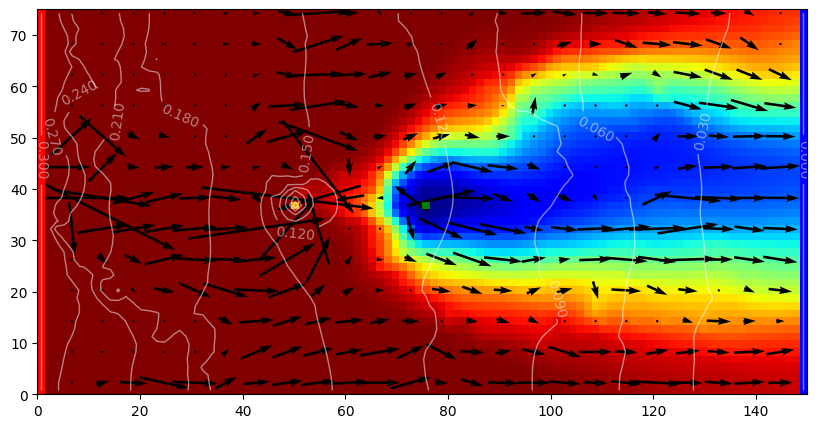

In [37]:
fig = plt.figure(figsize=(10, 5))
istep = 49
kstpkper = (istep, 0)
ml = fp.plot.PlotMapView(model=gwf, layer=2)
ml.plot_array(gwe.output.temperature().get_data(kstpkper), cmap="jet", vmin=7, vmax=10)

cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)
cont = ml.contour_array(gwf.output.head().get_data((0 ,0)), levels=10, colors="white", linewidths=1, alpha=.5)
# display head values on contour lines
plt.clabel(cont, fmt="%.3f")

ml.plot_vector(qx, qy, normalize=False, istep=4, jstep=4)
ml.plot_bc("CHD-1", color="red")
ml.plot_bc("CHD-2", color="blue")
ml.plot_bc("WEL-INJ", color="green")
ml.plot_bc("WEL-PROD", color="orange")

Check heat connection and see if the heat front is reaching (or not) the production well.

Text(0, 0.5, 'Temperature (°C)')

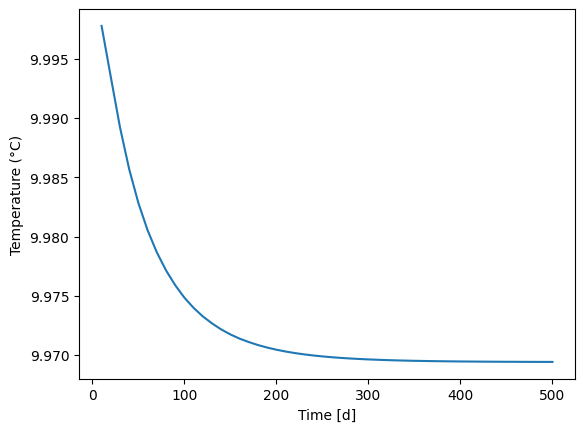

In [38]:
times = np.array(gwe.output.temperature().get_times())
plt.plot(times/86400, gwe.output.temperature().get_alldata()[:, *gwf.wel[1].stress_period_data.array[0].cellid[0]], label="Injection well")
plt.xlabel("Time [d]")
plt.ylabel("Temperature (°C)")

Temperature of production well is only decreasing by 0.03°C which is negligible. --> no major impact of the heat front on the production well.

Plot at first iteration (t=10 days)

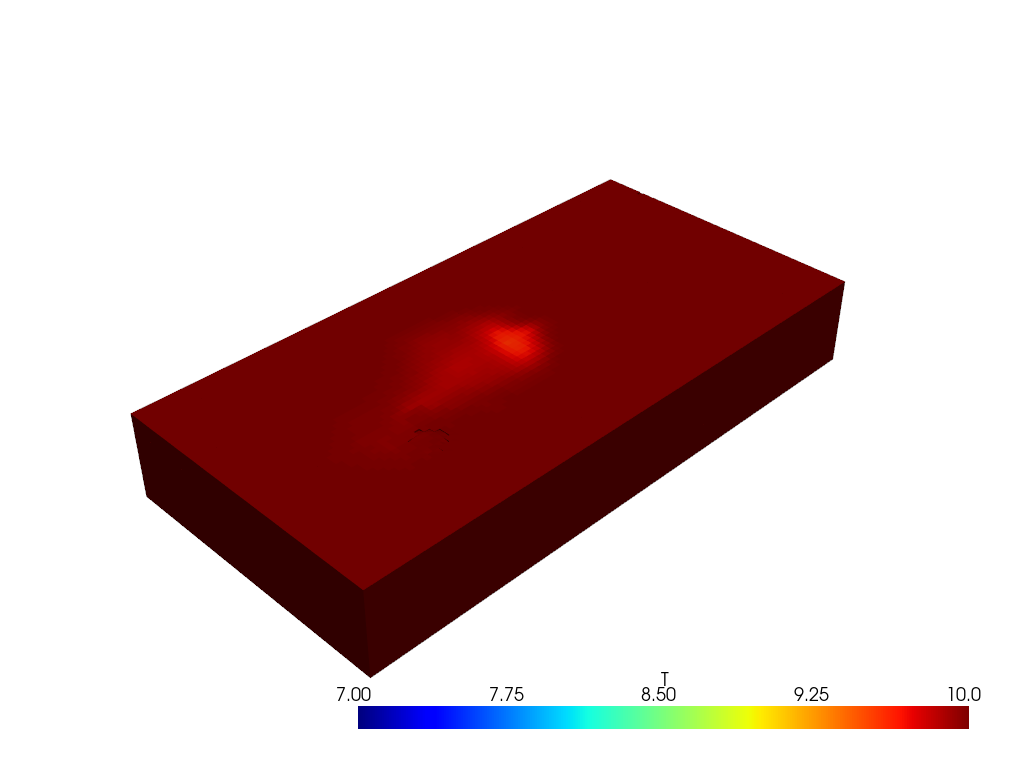

In [39]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(gwe.output.temperature().get_alldata()[0], name="T")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)
# ghosts = np.argwhere(gwf_mesh["T"] >= 9.9)
# gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=False, scalars="T", cmap="jet", clim=[7, 10])
pl.show()

Plot at last iteration (t=1000 days) the temperature distribution in the domain.

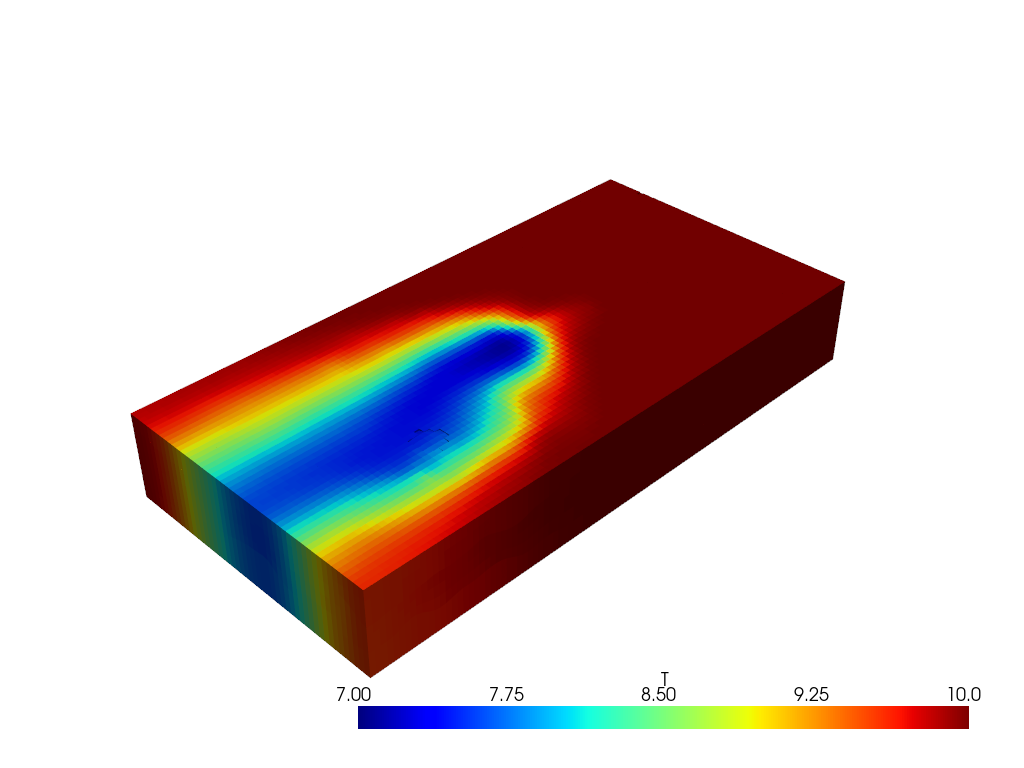

In [40]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(gwe.output.temperature().get_alldata()[-1], name="T")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)
# ghosts = np.argwhere(gwf_mesh["T"] >= 9.9)
# gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=False, scalars="T", cmap="jet", clim=[7, 10], edge_opacity=0.3)
pl.show()

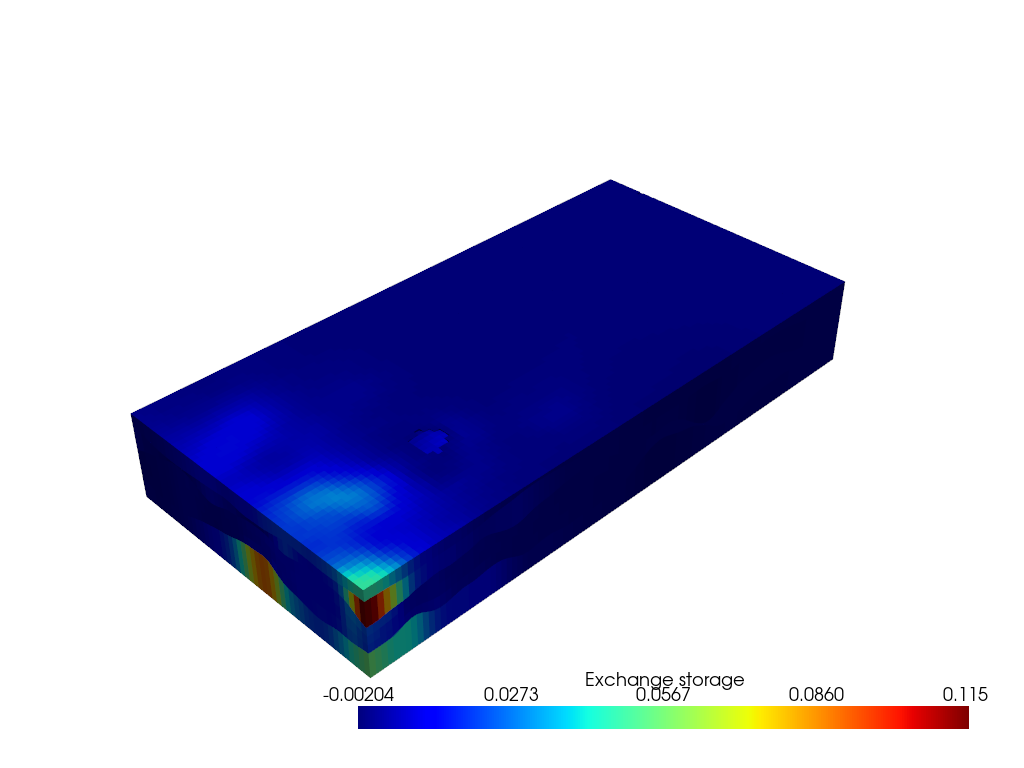

In [41]:
budget_e = gwe.output.budget()

from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(budget_e.get_data(text="STORAGE-CELLBLK", kstpkper=(49, 0))[0], name="Exchange storage")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)
# ghosts = np.argwhere(gwf_mesh["T"] >= 9.9)
# gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=False, scalars="Exchange storage", cmap="jet", edge_opacity=0.3)
pl.show()

c:\Users\schorppl\AppData\Local\miniconda3\envs\bebou\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


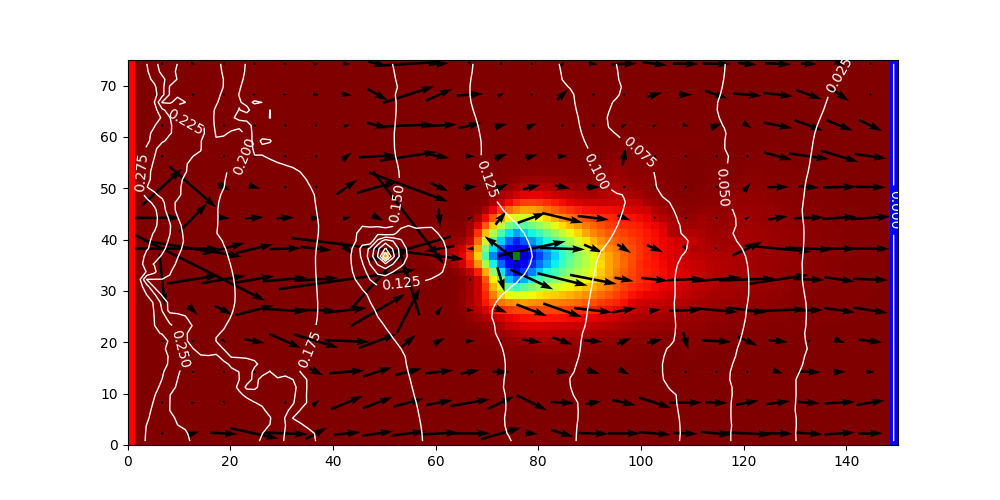

MovieWriter imagemagick unavailable; using Pillow instead.


In [42]:
%matplotlib widget
import matplotlib.animation as animation


fig = plt.figure(figsize=(10, 5))
istep = 0
kstpkper = (istep, 0)
ml = fp.plot.PlotMapView(model=gwf, layer=2)
ml.plot_array(gwe.output.temperature().get_data(kstpkper), cmap="jet", vmin=7, vmax=10)

cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)
cont = ml.contour_array(gwf.output.head().get_data((0 ,0)), levels=15, colors="white", linewidths=1)
# display head values on contour lines
plt.clabel(cont, fmt="%.3f")

ml.plot_vector(qx, qy, normalize=False, istep=4, jstep=4 )
ml.plot_bc("CHD-1", color="red")
ml.plot_bc("CHD-2", color="blue")
ml.plot_bc("WEL-INJ", color="green")
ml.plot_bc("WEL-PROD", color="orange")


def update(istep):

# i = 0
# istep = 2
    kstpkper = (istep, 0)
#     ml = fp.plot.PlotMapView(model=gwf, layer=2)
    ml.plot_array(gwe.output.temperature().get_data(kstpkper), cmap="jet", vmin=7, vmax=10)

    # cont = ml.contour_array(gwf.output.head().get_data((0 ,0)), levels=15, colors="white", linewidths=1)
    # # display head values on contour lines
    # plt.clabel(cont, fmt="%.3f")

    # ml.plot_vector(qx, qy, normalize=False, istep=4, jstep=4)
    ml.plot_bc("CHD-1", color="red")
    ml.plot_bc("CHD-2", color="blue")
    ml.plot_bc("WEL-INJ", color="green")
    ml.plot_bc("WEL-PROD", color="orange")

    plt.title(f"layer 2: Time {times[istep]/86400:.0f} d")
ani = animation.FuncAnimation(fig, update, frames=10,  interval=100, repeat=False)
plt.show()
ani.save("animation.gif", writer="imagemagick", fps=1)